In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix, f1_score

from model import get_model, save_checkpoint, load_checkpoint, get_cosine_schedule_with_warmup, create_loss_fn
from dataset import Dataset

In [2]:
reload_work = True

# Data generation

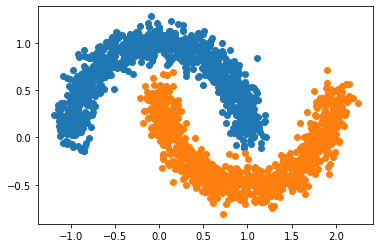

In [3]:
if reload_work:
    X = np.load('X.npy')
    y = np.load('y.npy')
#    X = X - np.asarray([2, 1])
    plt.scatter(X[y==0,0], X[y==0,1])
    plt.scatter(X[y==1,0], X[y==1,1])

## Data preparation for training

In [4]:
if reload_work:
    #seen_idx = np.load('seen_idx.npy')
    #unseen_idx = np.load('unseen_idx.npy')
    # using smallest seen idx
    idx_1 = np.random.choice(np.arange(len(X))[(y == 0) & (X[:,0] < 0) & (X[:,1] < 0)], 1)
    idx_2 = np.random.choice(np.arange(len(X))[(y == 0) & (X[:,0] < 0.4) & (X[:,0] > -0.4)], 1)
    idx_3 = np.random.choice(np.arange(len(X))[(y == 0) & (X[:,0] > 0) & (X[:,1] < 0)], 1)
    seen_idx_n = (list(idx_1) + list(idx_2) + list(idx_3))

    idx_1 = np.random.choice(np.arange(len(X))[(y == 1) & (X[:,0] < 1) & (X[:,1] > 0.2)], 1)
    idx_2 = np.random.choice(np.arange(len(X))[(y == 1) & (X[:,0] < 1.2) & (X[:,0] > 0.4)], 1)
    idx_3 = np.random.choice(np.arange(len(X))[(y == 1) & (X[:,0] > 1) & (X[:,1] > 0.2)], 1)
    seen_idx_p = (list(idx_1) + list(idx_2) + list(idx_3))
    seen_idx = seen_idx_p + seen_idx_n

    unseen_idx = list(set(list(range(len(X)))) - set(seen_idx))
    unseen_idx_train = np.random.choice(unseen_idx, int(len(unseen_idx) / 2), replace=False)
    unseen_idx_test = list(set(unseen_idx) - set(list(unseen_idx_train)))
    
    seen = Dataset(np.asarray(list(X[seen_idx])*2), np.asarray(list(y[seen_idx])*2).reshape([-1, 1]))
    unseen = Dataset(X[unseen_idx_train], y[unseen_idx_train].reshape([-1, 1]))

    seen_set = data.DataLoader(seen, batch_size=6, shuffle=True)
    unseen_set = data.DataLoader(unseen, batch_size=35, shuffle=True)

In [5]:
len(seen_idx), len(unseen_idx), len(unseen_idx_train), len(unseen_idx_test)

(6, 1994, 997, 997)

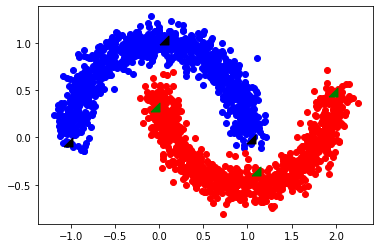

In [6]:
plt.scatter(X[y==0,0], X[y==0,1], color='blue')
plt.scatter(X[y==1,0], X[y==1,1], color='red')

seen_array = np.asarray([idx in seen_idx for idx in range(len(X))])
verts = np.array([[-1, -1], [1, -1], [1, 1], [-1, -1]])
plt.scatter(X[seen_array & (y==0),0], X[seen_array & (y==0),1], s=80, marker=verts, color='black')
plt.scatter(X[seen_array & (y==1),0], X[seen_array & (y==1),1], s=80, marker=verts, color='green')


# Meta Pseudo labeling training

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net_s, _, sgd_s = get_model(device)
net_t, _, sgd_t = get_model(device)

criterion = create_loss_fn(device)

#s_scheduler = get_cosine_schedule_with_warmup(sgd_s,
#                                              3000,
#                                              10000,
#                                              1000)

#t_scheduler = get_cosine_schedule_with_warmup(sgd_t,
#                                              500,
#                                              10000)

In [8]:
def focusing(y_pred, y):
    diff = np.abs(y - y_pred)
    select = diff > diff.mean()
    return y_pred[select], y[select]

In [9]:
cur_f1 = -1
ls_loss_s = []
ls_loss_t = []
seen_itr = iter(seen_set)
unseen_itr = iter(unseen_set)
for step in range(10000):
    # get data seen and unseen
    net_t.train()
    net_s.train()
    try:
        X_us, _ = unseen_itr.next()
    except:
        unseen_itr = iter(unseen_set)
        X_us, _ = unseen_itr.next()

    try:
        X_l, y_l = seen_itr.next()
    except:
        seen_itr = iter(seen_set)
        X_l, y_l = seen_itr.next()

    X_l = X_l.to(device).float()
    y_l = y_l.to(device).float()
    X_us = X_us.to(device).float()

    # inference seen and unseen batch by teacher
    l_size = X_l.shape[0]
    X_t = torch.cat((X_l, X_us))
    y_t = net_t(X_t)
    t_sigm_l = y_t[:l_size]
    t_sigm_us = y_t[l_size:]
    del y_t

    # calculate loss from seen batch by teacher
    t_loss_l = criterion(t_sigm_l, y_l)    

    t_sigm_us_temp = t_sigm_us.detach().numpy()
    t_sigm_us_temp = torch.tensor(t_sigm_us_temp).to(device).float()
    y_s = net_s(X_us)
    s_loss = criterion(y_s, t_sigm_us_temp)

    s_loss.backward()
    sgd_s.step()
    #s_scheduler.step()
    ls_loss_s.append(s_loss.detach().numpy())

    # inference seen from student
    with torch.no_grad():
        s_sigm_l = net_s(X_l)
    s_loss_l_new = criterion(s_sigm_l.detach(), y_l)

    # calculate gradient from student inference
    f_sigm_l, f_y_l = focusing(s_sigm_l.detach().numpy(), y_l.detach().numpy())
    f_sigm_l = torch.tensor(f_sigm_l).to(device).float()
    f_y_l = torch.tensor(f_y_l).to(device).float()
    
    # combine gradient from student and teacher to train teacher
    weight_u = (1 * min(1., (step + 1) / 10000))
    s_loss_l_new = criterion(f_sigm_l, f_y_l)
    t_loss = t_loss_l + s_loss_l_new * weight_u

    t_loss.backward()
    sgd_t.step()
    #t_scheduler.step()
    ls_loss_t.append(t_loss.detach().numpy())

    net_t.zero_grad()
    net_s.zero_grad()

    net_s.eval()
    y_pred = net_s(torch.tensor(X[unseen_idx_test]).to(device).float())
    y_pred_np = y_pred.detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y[unseen_idx_test], y_pred_np > 0.5).ravel()
    f1 = f1_score(y[unseen_idx_test], (y_pred_np > 0.5))
    if f1 > cur_f1:
        cur_f1 = f1
        save_checkpoint(net_s, sgd_s, 'model/meta-pseudo-labeling', step, f1)

    print(f'{step} tp {tp}, fp {fp}, tn {tn}, fn {fn}')

Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000000_f1-0.0.pth
0 tp 0, fp 0, tn 495, fn 502
1 tp 0, fp 0, tn 495, fn 502
2 tp 0, fp 0, tn 495, fn 502
3 tp 0, fp 0, tn 495, fn 502
4 tp 0, fp 0, tn 495, fn 502
5 tp 0, fp 0, tn 495, fn 502
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000006_f1-0.06177606177606178.pth
6 tp 16, fp 0, tn 495, fn 486
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000007_f1-0.3182579564489112.pth
7 tp 95, fp 0, tn 495, fn 407
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000008_f1-0.4601226993865031.pth
8 tp 150, fp 0, tn 495, fn 352
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000009_f1-0.5300146412884333.pth
9 tp 181, fp 0, tn 495, fn 321
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000010_f1-0.56657223796034.pth
10 tp 200, fp 4, tn 491, fn 302
11 tp 224, fp 65, tn 430, fn 278
12 tp 240, fp 169, tn 326, fn 262
13 tp 249, fp 241, tn 254, fn 253
14 tp

200 tp 259, fp 109, tn 386, fn 243
201 tp 254, fp 95, tn 400, fn 248
202 tp 252, fp 89, tn 406, fn 250
203 tp 254, fp 94, tn 401, fn 248
204 tp 259, fp 107, tn 388, fn 243
205 tp 255, fp 100, tn 395, fn 247
206 tp 268, fp 122, tn 373, fn 234
207 tp 259, fp 107, tn 388, fn 243
208 tp 267, fp 118, tn 377, fn 235
209 tp 259, fp 107, tn 388, fn 243
210 tp 254, fp 94, tn 401, fn 248
211 tp 255, fp 98, tn 397, fn 247
212 tp 268, fp 118, tn 377, fn 234
213 tp 273, fp 124, tn 371, fn 229
214 tp 279, fp 132, tn 363, fn 223
215 tp 267, fp 110, tn 385, fn 235
216 tp 274, fp 122, tn 373, fn 228
217 tp 282, fp 131, tn 364, fn 220
218 tp 276, fp 121, tn 374, fn 226
219 tp 283, fp 133, tn 362, fn 219
220 tp 282, fp 124, tn 371, fn 220
221 tp 287, fp 135, tn 360, fn 215
222 tp 285, fp 128, tn 367, fn 217
223 tp 279, fp 117, tn 378, fn 223
224 tp 281, fp 117, tn 378, fn 221
225 tp 289, fp 135, tn 360, fn 213
226 tp 299, fp 152, tn 343, fn 203
227 tp 301, fp 157, tn 338, fn 201
228 tp 301, fp 154, tn 34

370 tp 402, fp 137, tn 358, fn 100
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000371_f1-0.7751196172248803.pth
371 tp 405, fp 138, tn 357, fn 97
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000372_f1-0.7762906309751433.pth
372 tp 406, fp 138, tn 357, fn 96
373 tp 404, fp 137, tn 358, fn 98
374 tp 405, fp 137, tn 358, fn 97
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000375_f1-0.7770334928229665.pth
375 tp 406, fp 137, tn 358, fn 96
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000376_f1-0.7788461538461537.pth
376 tp 405, fp 133, tn 362, fn 97
377 tp 398, fp 131, tn 364, fn 104
378 tp 406, fp 137, tn 358, fn 96
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000379_f1-0.7800192122958693.pth
379 tp 406, fp 133, tn 362, fn 96
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000380_f1-0.7807692307692308.pth
380 tp 406, fp 132, tn 363, fn 96
Saved checkpoint: model/meta-pseudo-labeli

Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000490_f1-0.8482490272373542.pth
490 tp 436, fp 90, tn 405, fn 66
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000491_f1-0.849951597289448.pth
491 tp 439, fp 92, tn 403, fn 63
492 tp 436, fp 88, tn 407, fn 66
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000493_f1-0.8532818532818532.pth
493 tp 442, fp 92, tn 403, fn 60
494 tp 435, fp 86, tn 409, fn 67
495 tp 427, fp 77, tn 418, fn 75
496 tp 430, fp 82, tn 413, fn 72
497 tp 432, fp 84, tn 411, fn 70
498 tp 427, fp 76, tn 419, fn 75
499 tp 427, fp 72, tn 423, fn 75
500 tp 426, fp 71, tn 424, fn 76
501 tp 431, fp 78, tn 417, fn 71
502 tp 434, fp 84, tn 411, fn 68
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000503_f1-0.8576960309777347.pth
503 tp 443, fp 88, tn 407, fn 59
504 tp 444, fp 91, tn 404, fn 58
505 tp 443, fp 88, tn 407, fn 59
506 tp 434, fp 84, tn 411, fn 68
507 tp 434, fp 84, tn 411, fn 68
508 tp 427, fp 71, 

659 tp 428, fp 61, tn 434, fn 74
660 tp 418, fp 59, tn 436, fn 84
661 tp 433, fp 66, tn 429, fn 69
662 tp 448, fp 69, tn 426, fn 54
663 tp 454, fp 76, tn 419, fn 48
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000664_f1-0.882466281310212.pth
664 tp 458, fp 78, tn 417, fn 44
665 tp 439, fp 67, tn 428, fn 63
666 tp 412, fp 51, tn 444, fn 90
667 tp 424, fp 61, tn 434, fn 78
668 tp 431, fp 64, tn 431, fn 71
669 tp 430, fp 62, tn 433, fn 72
670 tp 449, fp 68, tn 427, fn 53
671 tp 448, fp 68, tn 427, fn 54
672 tp 456, fp 76, tn 419, fn 46
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000000673_f1-0.8826923076923078.pth
673 tp 459, fp 79, tn 416, fn 43
674 tp 416, fp 52, tn 443, fn 86
675 tp 413, fp 49, tn 446, fn 89
676 tp 424, fp 62, tn 433, fn 78
677 tp 437, fp 65, tn 430, fn 65
678 tp 408, fp 45, tn 450, fn 94
679 tp 418, fp 56, tn 439, fn 84
680 tp 431, fp 64, tn 431, fn 71
681 tp 424, fp 62, tn 433, fn 78
682 tp 440, fp 65, tn 430, fn 62
Saved checkpoin

890 tp 419, fp 66, tn 429, fn 83
891 tp 432, fp 68, tn 427, fn 70
892 tp 419, fp 65, tn 430, fn 83
893 tp 408, fp 63, tn 432, fn 94
894 tp 425, fp 66, tn 429, fn 77
895 tp 358, fp 22, tn 473, fn 144
896 tp 392, fp 50, tn 445, fn 110
897 tp 363, fp 25, tn 470, fn 139
898 tp 445, fp 77, tn 418, fn 57
899 tp 419, fp 66, tn 429, fn 83
900 tp 404, fp 62, tn 433, fn 98
901 tp 400, fp 57, tn 438, fn 102
902 tp 399, fp 53, tn 442, fn 103
903 tp 438, fp 69, tn 426, fn 64
904 tp 443, fp 75, tn 420, fn 59
905 tp 410, fp 64, tn 431, fn 92
906 tp 406, fp 64, tn 431, fn 96
907 tp 399, fp 53, tn 442, fn 103
908 tp 374, fp 35, tn 460, fn 128
909 tp 424, fp 66, tn 429, fn 78
910 tp 438, fp 70, tn 425, fn 64
911 tp 443, fp 75, tn 420, fn 59
912 tp 400, fp 61, tn 434, fn 102
913 tp 391, fp 50, tn 445, fn 111
914 tp 395, fp 51, tn 444, fn 107
915 tp 398, fp 53, tn 442, fn 104
916 tp 424, fp 67, tn 428, fn 78
917 tp 442, fp 75, tn 420, fn 60
918 tp 402, fp 62, tn 433, fn 100
919 tp 442, fp 75, tn 420, fn 6

1137 tp 413, fp 71, tn 424, fn 89
1138 tp 420, fp 76, tn 419, fn 82
1139 tp 384, fp 61, tn 434, fn 118
1140 tp 370, fp 54, tn 441, fn 132
1141 tp 465, fp 101, tn 394, fn 37
1142 tp 482, fp 105, tn 390, fn 20
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000001143_f1-0.8925022583559169.pth
1143 tp 494, fp 111, tn 384, fn 8
1144 tp 453, fp 89, tn 406, fn 49
1145 tp 420, fp 76, tn 419, fn 82
1146 tp 420, fp 76, tn 419, fn 82
1147 tp 409, fp 68, tn 427, fn 93
1148 tp 416, fp 74, tn 421, fn 86
1149 tp 379, fp 57, tn 438, fn 123
1150 tp 340, fp 16, tn 479, fn 162
1151 tp 378, fp 56, tn 439, fn 124
1152 tp 387, fp 62, tn 433, fn 115
1153 tp 399, fp 68, tn 427, fn 103
1154 tp 454, fp 97, tn 398, fn 48
1155 tp 457, fp 96, tn 399, fn 45
1156 tp 383, fp 61, tn 434, fn 119
1157 tp 385, fp 63, tn 432, fn 117
1158 tp 414, fp 75, tn 420, fn 88
1159 tp 362, fp 46, tn 449, fn 140
1160 tp 385, fp 63, tn 432, fn 117
1161 tp 366, fp 50, tn 445, fn 136
1162 tp 409, fp 69, tn 426, fn 93
1163 

1390 tp 354, fp 47, tn 448, fn 148
1391 tp 344, fp 36, tn 459, fn 158
1392 tp 354, fp 46, tn 449, fn 148
1393 tp 367, fp 60, tn 435, fn 135
1394 tp 395, fp 74, tn 421, fn 107
1395 tp 364, fp 59, tn 436, fn 138
1396 tp 380, fp 65, tn 430, fn 122
1397 tp 377, fp 64, tn 431, fn 125
1398 tp 423, fp 87, tn 408, fn 79
1399 tp 361, fp 55, tn 440, fn 141
1400 tp 386, fp 73, tn 422, fn 116
1401 tp 423, fp 87, tn 408, fn 79
1402 tp 398, fp 79, tn 416, fn 104
1403 tp 397, fp 78, tn 417, fn 105
1404 tp 423, fp 87, tn 408, fn 79
1405 tp 394, fp 71, tn 424, fn 108
1406 tp 469, fp 105, tn 390, fn 33
1407 tp 414, fp 79, tn 416, fn 88
1408 tp 455, fp 95, tn 400, fn 47
1409 tp 414, fp 78, tn 417, fn 88
1410 tp 419, fp 83, tn 412, fn 83
1411 tp 413, fp 78, tn 417, fn 89
1412 tp 430, fp 88, tn 407, fn 72
1413 tp 417, fp 78, tn 417, fn 85
1414 tp 389, fp 68, tn 427, fn 113
1415 tp 362, fp 59, tn 436, fn 140
1416 tp 361, fp 58, tn 437, fn 141
1417 tp 446, fp 88, tn 407, fn 56
1418 tp 465, fp 95, tn 400, fn 

1634 tp 427, fp 76, tn 419, fn 75
1635 tp 429, fp 83, tn 412, fn 73
1636 tp 416, fp 83, tn 412, fn 86
1637 tp 380, fp 68, tn 427, fn 122
1638 tp 361, fp 64, tn 431, fn 141
1639 tp 363, fp 65, tn 430, fn 139
1640 tp 365, fp 65, tn 430, fn 137
1641 tp 365, fp 65, tn 430, fn 137
1642 tp 424, fp 88, tn 407, fn 78
1643 tp 366, fp 67, tn 428, fn 136
1644 tp 388, fp 75, tn 420, fn 114
1645 tp 420, fp 83, tn 412, fn 82
1646 tp 373, fp 67, tn 428, fn 129
1647 tp 388, fp 77, tn 418, fn 114
1648 tp 422, fp 88, tn 407, fn 80
1649 tp 464, fp 101, tn 394, fn 38
1650 tp 355, fp 63, tn 432, fn 147
1651 tp 422, fp 94, tn 401, fn 80
1652 tp 358, fp 66, tn 429, fn 144
1653 tp 345, fp 60, tn 435, fn 157
1654 tp 386, fp 81, tn 414, fn 116
1655 tp 426, fp 95, tn 400, fn 76
1656 tp 387, fp 79, tn 416, fn 115
1657 tp 383, fp 76, tn 419, fn 119
1658 tp 378, fp 75, tn 420, fn 124
1659 tp 341, fp 58, tn 437, fn 161
1660 tp 395, fp 78, tn 417, fn 107
1661 tp 419, fp 88, tn 407, fn 83
1662 tp 414, fp 78, tn 417, f

1868 tp 419, fp 95, tn 400, fn 83
1869 tp 357, fp 74, tn 421, fn 145
1870 tp 417, fp 95, tn 400, fn 85
1871 tp 380, fp 82, tn 413, fn 122
1872 tp 421, fp 99, tn 396, fn 81
1873 tp 418, fp 95, tn 400, fn 84
1874 tp 438, fp 95, tn 400, fn 64
1875 tp 388, fp 83, tn 412, fn 114
1876 tp 371, fp 77, tn 418, fn 131
1877 tp 359, fp 73, tn 422, fn 143
1878 tp 375, fp 80, tn 415, fn 127
1879 tp 353, fp 70, tn 425, fn 149
1880 tp 388, fp 83, tn 412, fn 114
1881 tp 379, fp 78, tn 417, fn 123
1882 tp 394, fp 83, tn 412, fn 108
1883 tp 382, fp 82, tn 413, fn 120
1884 tp 436, fp 102, tn 393, fn 66
1885 tp 433, fp 95, tn 400, fn 69
1886 tp 415, fp 84, tn 411, fn 87
1887 tp 440, fp 88, tn 407, fn 62
1888 tp 442, fp 96, tn 399, fn 60
1889 tp 382, fp 83, tn 412, fn 120
1890 tp 360, fp 68, tn 427, fn 142
1891 tp 449, fp 101, tn 394, fn 53
1892 tp 413, fp 83, tn 412, fn 89
1893 tp 421, fp 83, tn 412, fn 81
1894 tp 456, fp 100, tn 395, fn 46
1895 tp 463, fp 97, tn 398, fn 39
1896 tp 415, fp 83, tn 412, fn 8

2127 tp 388, fp 78, tn 417, fn 114
2128 tp 397, fp 81, tn 414, fn 105
2129 tp 395, fp 75, tn 420, fn 107
2130 tp 428, fp 78, tn 417, fn 74
2131 tp 400, fp 74, tn 421, fn 102
2132 tp 445, fp 101, tn 394, fn 57
2133 tp 366, fp 77, tn 418, fn 136
2134 tp 367, fp 77, tn 418, fn 135
2135 tp 432, fp 88, tn 407, fn 70
2136 tp 376, fp 72, tn 423, fn 126
2137 tp 350, fp 70, tn 425, fn 152
2138 tp 333, fp 66, tn 429, fn 169
2139 tp 362, fp 68, tn 427, fn 140
2140 tp 400, fp 78, tn 417, fn 102
2141 tp 397, fp 84, tn 411, fn 105
2142 tp 424, fp 88, tn 407, fn 78
2143 tp 361, fp 68, tn 427, fn 141
2144 tp 410, fp 88, tn 407, fn 92
2145 tp 498, fp 128, tn 367, fn 4
2146 tp 410, fp 105, tn 390, fn 92
2147 tp 373, fp 84, tn 411, fn 129
2148 tp 374, fp 86, tn 409, fn 128
2149 tp 388, fp 88, tn 407, fn 114
2150 tp 374, fp 83, tn 412, fn 128
2151 tp 364, fp 83, tn 412, fn 138
2152 tp 366, fp 83, tn 412, fn 136
2153 tp 443, fp 101, tn 394, fn 59
2154 tp 446, fp 89, tn 406, fn 56
2155 tp 457, fp 83, tn 412

2371 tp 360, fp 74, tn 421, fn 142
2372 tp 388, fp 83, tn 412, fn 114
2373 tp 431, fp 97, tn 398, fn 71
2374 tp 454, fp 95, tn 400, fn 48
2375 tp 420, fp 83, tn 412, fn 82
2376 tp 434, fp 77, tn 418, fn 68
2377 tp 394, fp 88, tn 407, fn 108
2378 tp 461, fp 105, tn 390, fn 41
2379 tp 459, fp 101, tn 394, fn 43
2380 tp 388, fp 71, tn 424, fn 114
2381 tp 448, fp 83, tn 412, fn 54
2382 tp 395, fp 88, tn 407, fn 107
2383 tp 401, fp 88, tn 407, fn 101
2384 tp 478, fp 105, tn 390, fn 24
2385 tp 470, fp 104, tn 391, fn 32
2386 tp 403, fp 88, tn 407, fn 99
2387 tp 386, fp 83, tn 412, fn 116
2388 tp 384, fp 77, tn 418, fn 118
2389 tp 406, fp 69, tn 426, fn 96
2390 tp 411, fp 83, tn 412, fn 91
2391 tp 407, fp 83, tn 412, fn 95
2392 tp 348, fp 68, tn 427, fn 154
2393 tp 327, fp 66, tn 429, fn 175
2394 tp 377, fp 69, tn 426, fn 125
2395 tp 460, fp 87, tn 408, fn 42
2396 tp 408, fp 69, tn 426, fn 94
2397 tp 422, fp 83, tn 412, fn 80
2398 tp 394, fp 76, tn 419, fn 108
2399 tp 449, fp 83, tn 412, fn 5

2622 tp 410, fp 95, tn 400, fn 92
2623 tp 354, fp 71, tn 424, fn 148
2624 tp 386, fp 81, tn 414, fn 116
2625 tp 392, fp 78, tn 417, fn 110
2626 tp 364, fp 76, tn 419, fn 138
2627 tp 342, fp 68, tn 427, fn 160
2628 tp 389, fp 83, tn 412, fn 113
2629 tp 340, fp 76, tn 419, fn 162
2630 tp 364, fp 77, tn 418, fn 138
2631 tp 389, fp 83, tn 412, fn 113
2632 tp 378, fp 70, tn 425, fn 124
2633 tp 372, fp 68, tn 427, fn 130
2634 tp 414, fp 83, tn 412, fn 88
2635 tp 475, fp 86, tn 409, fn 27
2636 tp 427, fp 78, tn 417, fn 75
2637 tp 388, fp 68, tn 427, fn 114
2638 tp 420, fp 88, tn 407, fn 82
2639 tp 466, fp 91, tn 404, fn 36
2640 tp 443, fp 83, tn 412, fn 59
2641 tp 356, fp 66, tn 429, fn 146
2642 tp 370, fp 66, tn 429, fn 132
2643 tp 413, fp 84, tn 411, fn 89
2644 tp 377, fp 82, tn 413, fn 125
2645 tp 423, fp 97, tn 398, fn 79
2646 tp 370, fp 83, tn 412, fn 132
2647 tp 404, fp 95, tn 400, fn 98
2648 tp 391, fp 90, tn 405, fn 111
2649 tp 371, fp 83, tn 412, fn 131
2650 tp 382, fp 88, tn 407, fn

2891 tp 404, fp 89, tn 406, fn 98
2892 tp 426, fp 98, tn 397, fn 76
2893 tp 415, fp 97, tn 398, fn 87
2894 tp 388, fp 90, tn 405, fn 114
2895 tp 446, fp 110, tn 385, fn 56
2896 tp 449, fp 112, tn 383, fn 53
2897 tp 400, fp 95, tn 400, fn 102
2898 tp 373, fp 89, tn 406, fn 129
2899 tp 397, fp 83, tn 412, fn 105
2900 tp 372, fp 73, tn 422, fn 130
2901 tp 444, fp 99, tn 396, fn 58
2902 tp 367, fp 78, tn 417, fn 135
2903 tp 367, fp 78, tn 417, fn 135
2904 tp 427, fp 84, tn 411, fn 75
2905 tp 451, fp 84, tn 411, fn 51
2906 tp 399, fp 75, tn 420, fn 103
2907 tp 373, fp 68, tn 427, fn 129
2908 tp 428, fp 88, tn 407, fn 74
2909 tp 397, fp 83, tn 412, fn 105
2910 tp 367, fp 78, tn 417, fn 135
2911 tp 398, fp 88, tn 407, fn 104
2912 tp 403, fp 89, tn 406, fn 99
2913 tp 408, fp 88, tn 407, fn 94
2914 tp 440, fp 84, tn 411, fn 62
2915 tp 334, fp 68, tn 427, fn 168
2916 tp 389, fp 83, tn 412, fn 113
2917 tp 478, fp 101, tn 394, fn 24
2918 tp 441, fp 95, tn 400, fn 61
2919 tp 404, fp 96, tn 399, fn 

3170 tp 445, fp 78, tn 417, fn 57
3171 tp 404, fp 88, tn 407, fn 98
3172 tp 363, fp 81, tn 414, fn 139
3173 tp 360, fp 78, tn 417, fn 142
3174 tp 383, fp 83, tn 412, fn 119
3175 tp 346, fp 70, tn 425, fn 156
3176 tp 406, fp 83, tn 412, fn 96
3177 tp 403, fp 88, tn 407, fn 99
3178 tp 344, fp 67, tn 428, fn 158
3179 tp 348, fp 68, tn 427, fn 154
3180 tp 449, fp 86, tn 409, fn 53
3181 tp 421, fp 83, tn 412, fn 81
3182 tp 334, fp 68, tn 427, fn 168
3183 tp 354, fp 66, tn 429, fn 148
3184 tp 484, fp 105, tn 390, fn 18
3185 tp 412, fp 95, tn 400, fn 90
3186 tp 401, fp 89, tn 406, fn 101
3187 tp 402, fp 83, tn 412, fn 100
3188 tp 366, fp 72, tn 423, fn 136
3189 tp 395, fp 86, tn 409, fn 107
3190 tp 409, fp 95, tn 400, fn 93
3191 tp 356, fp 78, tn 417, fn 146
3192 tp 405, fp 83, tn 412, fn 97
3193 tp 382, fp 78, tn 417, fn 120
3194 tp 402, fp 83, tn 412, fn 100
3195 tp 361, fp 77, tn 418, fn 141
3196 tp 353, fp 72, tn 423, fn 149
3197 tp 334, fp 68, tn 427, fn 168
3198 tp 363, fp 73, tn 422, f

3430 tp 381, fp 83, tn 412, fn 121
3431 tp 408, fp 98, tn 397, fn 94
3432 tp 373, fp 88, tn 407, fn 129
3433 tp 335, fp 83, tn 412, fn 167
3434 tp 394, fp 84, tn 411, fn 108
3435 tp 427, fp 85, tn 410, fn 75
3436 tp 385, fp 72, tn 423, fn 117
3437 tp 362, fp 70, tn 425, fn 140
3438 tp 445, fp 90, tn 405, fn 57
3439 tp 444, fp 90, tn 405, fn 58
3440 tp 459, fp 88, tn 407, fn 43
3441 tp 379, fp 78, tn 417, fn 123
3442 tp 381, fp 78, tn 417, fn 121
3443 tp 406, fp 83, tn 412, fn 96
3444 tp 451, fp 84, tn 411, fn 51
3445 tp 389, fp 67, tn 428, fn 113
3446 tp 403, fp 73, tn 422, fn 99
3447 tp 371, fp 67, tn 428, fn 131
3448 tp 380, fp 69, tn 426, fn 122
3449 tp 418, fp 78, tn 417, fn 84
3450 tp 454, fp 86, tn 409, fn 48
3451 tp 424, fp 77, tn 418, fn 78
3452 tp 412, fp 68, tn 427, fn 90
3453 tp 390, fp 67, tn 428, fn 112
3454 tp 422, fp 69, tn 426, fn 80
3455 tp 455, fp 69, tn 426, fn 47
3456 tp 437, fp 70, tn 425, fn 65
3457 tp 400, fp 66, tn 429, fn 102
3458 tp 400, fp 66, tn 429, fn 102


3673 tp 421, fp 64, tn 431, fn 81
3674 tp 445, fp 72, tn 423, fn 57
3675 tp 429, fp 67, tn 428, fn 73
3676 tp 299, fp 40, tn 455, fn 203
3677 tp 311, fp 48, tn 447, fn 191
3678 tp 361, fp 62, tn 433, fn 141
3679 tp 408, fp 77, tn 418, fn 94
3680 tp 391, fp 72, tn 423, fn 111
3681 tp 399, fp 73, tn 422, fn 103
3682 tp 388, fp 68, tn 427, fn 114
3683 tp 410, fp 69, tn 426, fn 92
3684 tp 420, fp 68, tn 427, fn 82
3685 tp 394, fp 66, tn 429, fn 108
3686 tp 365, fp 63, tn 432, fn 137
3687 tp 407, fp 72, tn 423, fn 95
3688 tp 448, fp 78, tn 417, fn 54
3689 tp 494, fp 104, tn 391, fn 8
3690 tp 494, fp 98, tn 397, fn 8
3691 tp 477, fp 83, tn 412, fn 25
3692 tp 451, fp 83, tn 412, fn 51
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000003693_f1-0.9099350046425255.pth
3693 tp 490, fp 85, tn 410, fn 12
3694 tp 486, fp 94, tn 401, fn 16
3695 tp 408, fp 78, tn 417, fn 94
3696 tp 334, fp 66, tn 429, fn 168
3697 tp 380, fp 70, tn 425, fn 122
3698 tp 391, fp 78, tn 417, fn 111
3699 tp 3

3908 tp 423, fp 83, tn 412, fn 79
3909 tp 424, fp 77, tn 418, fn 78
3910 tp 424, fp 70, tn 425, fn 78
3911 tp 493, fp 93, tn 402, fn 9
3912 tp 426, fp 71, tn 424, fn 76
3913 tp 407, fp 68, tn 427, fn 95
3914 tp 397, fp 67, tn 428, fn 105
3915 tp 386, fp 67, tn 428, fn 116
3916 tp 397, fp 66, tn 429, fn 105
3917 tp 333, fp 56, tn 439, fn 169
3918 tp 381, fp 62, tn 433, fn 121
3919 tp 406, fp 67, tn 428, fn 96
3920 tp 405, fp 67, tn 428, fn 97
3921 tp 400, fp 66, tn 429, fn 102
3922 tp 360, fp 64, tn 431, fn 142
3923 tp 351, fp 49, tn 446, fn 151
3924 tp 377, fp 56, tn 439, fn 125
3925 tp 361, fp 53, tn 442, fn 141
3926 tp 333, fp 49, tn 446, fn 169
3927 tp 397, fp 78, tn 417, fn 105
3928 tp 348, fp 67, tn 428, fn 154
3929 tp 370, fp 67, tn 428, fn 132
3930 tp 366, fp 64, tn 431, fn 136
3931 tp 399, fp 69, tn 426, fn 103
3932 tp 412, fp 68, tn 427, fn 90
3933 tp 394, fp 66, tn 429, fn 108
3934 tp 409, fp 66, tn 429, fn 93
3935 tp 448, fp 67, tn 428, fn 54
3936 tp 486, fp 83, tn 412, fn 1

4152 tp 430, fp 56, tn 439, fn 72
4153 tp 451, fp 56, tn 439, fn 51
4154 tp 481, fp 64, tn 431, fn 21
4155 tp 470, fp 62, tn 433, fn 32
4156 tp 466, fp 63, tn 432, fn 36
4157 tp 437, fp 59, tn 436, fn 65
4158 tp 433, fp 59, tn 436, fn 69
4159 tp 479, fp 66, tn 429, fn 23
4160 tp 446, fp 63, tn 432, fn 56
4161 tp 390, fp 60, tn 435, fn 112
4162 tp 411, fp 55, tn 440, fn 91
4163 tp 473, fp 64, tn 431, fn 29
4164 tp 342, fp 39, tn 456, fn 160
4165 tp 306, fp 39, tn 456, fn 196
4166 tp 320, fp 59, tn 436, fn 182
4167 tp 332, fp 63, tn 432, fn 170
4168 tp 387, fp 63, tn 432, fn 115
4169 tp 408, fp 59, tn 436, fn 94
4170 tp 411, fp 63, tn 432, fn 91
4171 tp 358, fp 46, tn 449, fn 144
4172 tp 384, fp 59, tn 436, fn 118
4173 tp 381, fp 55, tn 440, fn 121
4174 tp 463, fp 75, tn 420, fn 39
4175 tp 462, fp 75, tn 420, fn 40
4176 tp 466, fp 72, tn 423, fn 36
4177 tp 410, fp 65, tn 430, fn 92
4178 tp 319, fp 42, tn 453, fn 183
4179 tp 293, fp 38, tn 457, fn 209
4180 tp 380, fp 48, tn 447, fn 122
41

4394 tp 459, fp 44, tn 451, fn 43
4395 tp 386, fp 8, tn 487, fn 116
4396 tp 433, fp 45, tn 450, fn 69
4397 tp 457, fp 57, tn 438, fn 45
4398 tp 392, fp 30, tn 465, fn 110
4399 tp 348, fp 15, tn 480, fn 154
4400 tp 357, fp 13, tn 482, fn 145
4401 tp 394, fp 24, tn 471, fn 108
4402 tp 366, fp 15, tn 480, fn 136
4403 tp 358, fp 16, tn 479, fn 144
4404 tp 469, fp 51, tn 444, fn 33
4405 tp 472, fp 52, tn 443, fn 30
4406 tp 364, fp 23, tn 472, fn 138
4407 tp 426, fp 63, tn 432, fn 76
4408 tp 489, fp 69, tn 426, fn 13
4409 tp 439, fp 46, tn 449, fn 63
4410 tp 465, fp 53, tn 442, fn 37
4411 tp 403, fp 52, tn 443, fn 99
4412 tp 349, fp 31, tn 464, fn 153
4413 tp 477, fp 53, tn 442, fn 25
4414 tp 441, fp 34, tn 461, fn 61
4415 tp 470, fp 37, tn 458, fn 32
4416 tp 473, fp 41, tn 454, fn 29
4417 tp 461, fp 26, tn 469, fn 41
4418 tp 477, fp 45, tn 450, fn 25
4419 tp 459, fp 42, tn 453, fn 43
4420 tp 394, fp 23, tn 472, fn 108
4421 tp 377, fp 41, tn 454, fn 125
4422 tp 378, fp 43, tn 452, fn 124
442

4618 tp 449, fp 16, tn 479, fn 53
4619 tp 407, fp 16, tn 479, fn 95
4620 tp 414, fp 26, tn 469, fn 88
4621 tp 360, fp 16, tn 479, fn 142
4622 tp 399, fp 9, tn 486, fn 103
4623 tp 397, fp 8, tn 487, fn 105
4624 tp 410, fp 13, tn 482, fn 92
4625 tp 457, fp 50, tn 445, fn 45
4626 tp 424, fp 16, tn 479, fn 78
4627 tp 418, fp 19, tn 476, fn 84
4628 tp 462, fp 26, tn 469, fn 40
4629 tp 423, fp 17, tn 478, fn 79
4630 tp 464, fp 17, tn 478, fn 38
4631 tp 493, fp 60, tn 435, fn 9
4632 tp 418, fp 19, tn 476, fn 84
4633 tp 364, fp 16, tn 479, fn 138
4634 tp 368, fp 13, tn 482, fn 134
4635 tp 451, fp 22, tn 473, fn 51
4636 tp 484, fp 36, tn 459, fn 18
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000004637_f1-0.9575518262586377.pth
4637 tp 485, fp 26, tn 469, fn 17
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000004638_f1-0.9623015873015873.pth
4638 tp 485, fp 21, tn 474, fn 17
4639 tp 462, fp 16, tn 479, fn 40
4640 tp 471, fp 14, tn 481, fn 31
4641 tp 471, fp 17, tn

4862 tp 465, fp 8, tn 487, fn 37
4863 tp 433, fp 4, tn 491, fn 69
4864 tp 474, fp 9, tn 486, fn 28
4865 tp 448, fp 19, tn 476, fn 54
4866 tp 476, fp 14, tn 481, fn 26
4867 tp 437, fp 6, tn 489, fn 65
4868 tp 454, fp 10, tn 485, fn 48
4869 tp 476, fp 19, tn 476, fn 26
4870 tp 457, fp 19, tn 476, fn 45
4871 tp 392, fp 7, tn 488, fn 110
4872 tp 374, fp 4, tn 491, fn 128
4873 tp 373, fp 19, tn 476, fn 129
4874 tp 354, fp 7, tn 488, fn 148
4875 tp 448, fp 16, tn 479, fn 54
4876 tp 351, fp 16, tn 479, fn 151
4877 tp 352, fp 8, tn 487, fn 150
4878 tp 407, fp 10, tn 485, fn 95
4879 tp 413, fp 10, tn 485, fn 89
4880 tp 401, fp 5, tn 490, fn 101
4881 tp 451, fp 4, tn 491, fn 51
4882 tp 480, fp 7, tn 488, fn 22
4883 tp 449, fp 4, tn 491, fn 53
4884 tp 485, fp 14, tn 481, fn 17
Saved checkpoint: model/meta-pseudo-labeling/checkpoint_epoch000004885_f1-0.9743589743589745.pth
4885 tp 494, fp 18, tn 477, fn 8
4886 tp 480, fp 10, tn 485, fn 22
4887 tp 465, fp 14, tn 481, fn 37
4888 tp 468, fp 14, tn 48

5114 tp 490, fp 5, tn 490, fn 12
5115 tp 483, fp 5, tn 490, fn 19
5116 tp 482, fp 4, tn 491, fn 20
5117 tp 457, fp 4, tn 491, fn 45
5118 tp 466, fp 2, tn 493, fn 36
5119 tp 473, fp 10, tn 485, fn 29
5120 tp 391, fp 14, tn 481, fn 111
5121 tp 405, fp 14, tn 481, fn 97
5122 tp 466, fp 29, tn 466, fn 36
5123 tp 414, fp 7, tn 488, fn 88
5124 tp 393, fp 6, tn 489, fn 109
5125 tp 351, fp 5, tn 490, fn 151
5126 tp 337, fp 3, tn 492, fn 165
5127 tp 395, fp 7, tn 488, fn 107
5128 tp 357, fp 6, tn 489, fn 145
5129 tp 460, fp 4, tn 491, fn 42
5130 tp 479, fp 3, tn 492, fn 23
5131 tp 492, fp 14, tn 481, fn 10
5132 tp 340, fp 5, tn 490, fn 162
5133 tp 371, fp 3, tn 492, fn 131
5134 tp 410, fp 5, tn 490, fn 92
5135 tp 482, fp 5, tn 490, fn 20
5136 tp 493, fp 12, tn 483, fn 9
5137 tp 438, fp 7, tn 488, fn 64
5138 tp 484, fp 6, tn 489, fn 18
5139 tp 446, fp 4, tn 491, fn 56
5140 tp 408, fp 4, tn 491, fn 94
5141 tp 431, fp 2, tn 493, fn 71
5142 tp 441, fp 13, tn 482, fn 61
5143 tp 473, fp 12, tn 483, f

5374 tp 425, fp 2, tn 493, fn 77
5375 tp 437, fp 4, tn 491, fn 65
5376 tp 441, fp 0, tn 495, fn 61
5377 tp 474, fp 1, tn 494, fn 28
5378 tp 448, fp 0, tn 495, fn 54
5379 tp 468, fp 5, tn 490, fn 34
5380 tp 467, fp 4, tn 491, fn 35
5381 tp 468, fp 5, tn 490, fn 34
5382 tp 439, fp 4, tn 491, fn 63
5383 tp 448, fp 4, tn 491, fn 54
5384 tp 471, fp 4, tn 491, fn 31
5385 tp 441, fp 12, tn 483, fn 61
5386 tp 462, fp 13, tn 482, fn 40
5387 tp 443, fp 17, tn 478, fn 59
5388 tp 378, fp 4, tn 491, fn 124
5389 tp 449, fp 5, tn 490, fn 53
5390 tp 476, fp 4, tn 491, fn 26
5391 tp 437, fp 4, tn 491, fn 65
5392 tp 439, fp 4, tn 491, fn 63
5393 tp 471, fp 2, tn 493, fn 31
5394 tp 418, fp 0, tn 495, fn 84
5395 tp 403, fp 0, tn 495, fn 99
5396 tp 461, fp 1, tn 494, fn 41
5397 tp 464, fp 2, tn 493, fn 38
5398 tp 447, fp 1, tn 494, fn 55
5399 tp 468, fp 4, tn 491, fn 34
5400 tp 393, fp 4, tn 491, fn 109
5401 tp 394, fp 6, tn 489, fn 108
5402 tp 417, fp 6, tn 489, fn 85
5403 tp 444, fp 4, tn 491, fn 58
5404

5639 tp 442, fp 4, tn 491, fn 60
5640 tp 396, fp 2, tn 493, fn 106
5641 tp 483, fp 10, tn 485, fn 19
5642 tp 488, fp 18, tn 477, fn 14
5643 tp 448, fp 4, tn 491, fn 54
5644 tp 460, fp 8, tn 487, fn 42
5645 tp 326, fp 2, tn 493, fn 176
5646 tp 416, fp 4, tn 491, fn 86
5647 tp 386, fp 2, tn 493, fn 116
5648 tp 399, fp 3, tn 492, fn 103
5649 tp 420, fp 5, tn 490, fn 82
5650 tp 366, fp 2, tn 493, fn 136
5651 tp 420, fp 4, tn 491, fn 82
5652 tp 466, fp 4, tn 491, fn 36
5653 tp 392, fp 2, tn 493, fn 110
5654 tp 459, fp 3, tn 492, fn 43
5655 tp 432, fp 4, tn 491, fn 70
5656 tp 383, fp 5, tn 490, fn 119
5657 tp 443, fp 8, tn 487, fn 59
5658 tp 478, fp 8, tn 487, fn 24
5659 tp 391, fp 4, tn 491, fn 111
5660 tp 464, fp 9, tn 486, fn 38
5661 tp 381, fp 4, tn 491, fn 121
5662 tp 406, fp 4, tn 491, fn 96
5663 tp 373, fp 2, tn 493, fn 129
5664 tp 446, fp 5, tn 490, fn 56
5665 tp 433, fp 4, tn 491, fn 69
5666 tp 469, fp 3, tn 492, fn 33
5667 tp 432, fp 0, tn 495, fn 70
5668 tp 444, fp 2, tn 493, fn 5

5889 tp 360, fp 1, tn 494, fn 142
5890 tp 441, fp 2, tn 493, fn 61
5891 tp 404, fp 2, tn 493, fn 98
5892 tp 462, fp 4, tn 491, fn 40
5893 tp 405, fp 2, tn 493, fn 97
5894 tp 440, fp 3, tn 492, fn 62
5895 tp 445, fp 4, tn 491, fn 57
5896 tp 428, fp 4, tn 491, fn 74
5897 tp 389, fp 1, tn 494, fn 113
5898 tp 408, fp 2, tn 493, fn 94
5899 tp 484, fp 7, tn 488, fn 18
5900 tp 481, fp 3, tn 492, fn 21
5901 tp 434, fp 2, tn 493, fn 68
5902 tp 386, fp 1, tn 494, fn 116
5903 tp 482, fp 4, tn 491, fn 20
5904 tp 458, fp 4, tn 491, fn 44
5905 tp 448, fp 4, tn 491, fn 54
5906 tp 347, fp 2, tn 493, fn 155
5907 tp 406, fp 2, tn 493, fn 96
5908 tp 474, fp 4, tn 491, fn 28
5909 tp 415, fp 4, tn 491, fn 87
5910 tp 412, fp 8, tn 487, fn 90
5911 tp 462, fp 4, tn 491, fn 40
5912 tp 465, fp 5, tn 490, fn 37
5913 tp 411, fp 2, tn 493, fn 91
5914 tp 442, fp 4, tn 491, fn 60
5915 tp 395, fp 3, tn 492, fn 107
5916 tp 440, fp 2, tn 493, fn 62
5917 tp 444, fp 2, tn 493, fn 58
5918 tp 427, fp 4, tn 491, fn 75
5919 

6167 tp 468, fp 4, tn 491, fn 34
6168 tp 380, fp 2, tn 493, fn 122
6169 tp 449, fp 3, tn 492, fn 53
6170 tp 417, fp 2, tn 493, fn 85
6171 tp 378, fp 1, tn 494, fn 124
6172 tp 393, fp 2, tn 493, fn 109
6173 tp 399, fp 2, tn 493, fn 103
6174 tp 455, fp 3, tn 492, fn 47
6175 tp 447, fp 3, tn 492, fn 55
6176 tp 391, fp 3, tn 492, fn 111
6177 tp 449, fp 7, tn 488, fn 53
6178 tp 460, fp 4, tn 491, fn 42
6179 tp 423, fp 0, tn 495, fn 79
6180 tp 423, fp 2, tn 493, fn 79
6181 tp 407, fp 1, tn 494, fn 95
6182 tp 466, fp 11, tn 484, fn 36
6183 tp 427, fp 7, tn 488, fn 75
6184 tp 422, fp 4, tn 491, fn 80
6185 tp 360, fp 2, tn 493, fn 142
6186 tp 427, fp 4, tn 491, fn 75
6187 tp 479, fp 10, tn 485, fn 23
6188 tp 413, fp 5, tn 490, fn 89
6189 tp 393, fp 4, tn 491, fn 109
6190 tp 405, fp 3, tn 492, fn 97
6191 tp 374, fp 0, tn 495, fn 128
6192 tp 385, fp 0, tn 495, fn 117
6193 tp 401, fp 0, tn 495, fn 101
6194 tp 415, fp 2, tn 493, fn 87
6195 tp 459, fp 6, tn 489, fn 43
6196 tp 472, fp 10, tn 485, fn 

6425 tp 416, fp 4, tn 491, fn 86
6426 tp 402, fp 2, tn 493, fn 100
6427 tp 404, fp 1, tn 494, fn 98
6428 tp 394, fp 1, tn 494, fn 108
6429 tp 408, fp 3, tn 492, fn 94
6430 tp 365, fp 2, tn 493, fn 137
6431 tp 405, fp 4, tn 491, fn 97
6432 tp 403, fp 3, tn 492, fn 99
6433 tp 465, fp 4, tn 491, fn 37
6434 tp 448, fp 2, tn 493, fn 54
6435 tp 459, fp 1, tn 494, fn 43
6436 tp 484, fp 3, tn 492, fn 18
6437 tp 491, fp 8, tn 487, fn 11
6438 tp 492, fp 15, tn 480, fn 10
6439 tp 469, fp 4, tn 491, fn 33
6440 tp 429, fp 3, tn 492, fn 73
6441 tp 392, fp 1, tn 494, fn 110
6442 tp 379, fp 0, tn 495, fn 123
6443 tp 402, fp 2, tn 493, fn 100
6444 tp 408, fp 2, tn 493, fn 94
6445 tp 398, fp 2, tn 493, fn 104
6446 tp 455, fp 4, tn 491, fn 47
6447 tp 467, fp 4, tn 491, fn 35
6448 tp 472, fp 3, tn 492, fn 30
6449 tp 478, fp 4, tn 491, fn 24
6450 tp 373, fp 0, tn 495, fn 129
6451 tp 358, fp 0, tn 495, fn 144
6452 tp 345, fp 1, tn 494, fn 157
6453 tp 405, fp 4, tn 491, fn 97
6454 tp 482, fp 3, tn 492, fn 20

6688 tp 391, fp 4, tn 491, fn 111
6689 tp 423, fp 3, tn 492, fn 79
6690 tp 426, fp 3, tn 492, fn 76
6691 tp 423, fp 2, tn 493, fn 79
6692 tp 390, fp 0, tn 495, fn 112
6693 tp 359, fp 0, tn 495, fn 143
6694 tp 468, fp 1, tn 494, fn 34
6695 tp 478, fp 3, tn 492, fn 24
6696 tp 448, fp 1, tn 494, fn 54
6697 tp 436, fp 1, tn 494, fn 66
6698 tp 474, fp 3, tn 492, fn 28
6699 tp 481, fp 3, tn 492, fn 21
6700 tp 467, fp 2, tn 493, fn 35
6701 tp 413, fp 2, tn 493, fn 89
6702 tp 446, fp 1, tn 494, fn 56
6703 tp 451, fp 1, tn 494, fn 51
6704 tp 461, fp 4, tn 491, fn 41
6705 tp 461, fp 15, tn 480, fn 41
6706 tp 412, fp 6, tn 489, fn 90
6707 tp 373, fp 4, tn 491, fn 129
6708 tp 425, fp 5, tn 490, fn 77
6709 tp 359, fp 2, tn 493, fn 143
6710 tp 412, fp 4, tn 491, fn 90
6711 tp 401, fp 4, tn 491, fn 101
6712 tp 395, fp 7, tn 488, fn 107
6713 tp 392, fp 8, tn 487, fn 110
6714 tp 404, fp 1, tn 494, fn 98
6715 tp 461, fp 3, tn 492, fn 41
6716 tp 402, fp 1, tn 494, fn 100
6717 tp 472, fp 1, tn 494, fn 30


6962 tp 434, fp 4, tn 491, fn 68
6963 tp 418, fp 4, tn 491, fn 84
6964 tp 434, fp 4, tn 491, fn 68
6965 tp 472, fp 8, tn 487, fn 30
6966 tp 411, fp 5, tn 490, fn 91
6967 tp 449, fp 5, tn 490, fn 53
6968 tp 408, fp 1, tn 494, fn 94
6969 tp 379, fp 1, tn 494, fn 123
6970 tp 445, fp 7, tn 488, fn 57
6971 tp 407, fp 1, tn 494, fn 95
6972 tp 410, fp 1, tn 494, fn 92
6973 tp 434, fp 1, tn 494, fn 68
6974 tp 404, fp 1, tn 494, fn 98
6975 tp 350, fp 0, tn 495, fn 152
6976 tp 421, fp 1, tn 494, fn 81
6977 tp 372, fp 0, tn 495, fn 130
6978 tp 421, fp 0, tn 495, fn 81
6979 tp 404, fp 0, tn 495, fn 98
6980 tp 382, fp 0, tn 495, fn 120
6981 tp 475, fp 5, tn 490, fn 27
6982 tp 420, fp 0, tn 495, fn 82
6983 tp 390, fp 0, tn 495, fn 112
6984 tp 417, fp 0, tn 495, fn 85
6985 tp 449, fp 4, tn 491, fn 53
6986 tp 435, fp 4, tn 491, fn 67
6987 tp 457, fp 8, tn 487, fn 45
6988 tp 469, fp 4, tn 491, fn 33
6989 tp 477, fp 4, tn 491, fn 25
6990 tp 418, fp 2, tn 493, fn 84
6991 tp 403, fp 1, tn 494, fn 99
6992 

7241 tp 412, fp 4, tn 491, fn 90
7242 tp 441, fp 8, tn 487, fn 61
7243 tp 422, fp 4, tn 491, fn 80
7244 tp 413, fp 2, tn 493, fn 89
7245 tp 422, fp 1, tn 494, fn 80
7246 tp 447, fp 3, tn 492, fn 55
7247 tp 412, fp 1, tn 494, fn 90
7248 tp 389, fp 1, tn 494, fn 113
7249 tp 406, fp 1, tn 494, fn 96
7250 tp 401, fp 1, tn 494, fn 101
7251 tp 372, fp 0, tn 495, fn 130
7252 tp 431, fp 2, tn 493, fn 71
7253 tp 370, fp 1, tn 494, fn 132
7254 tp 478, fp 5, tn 490, fn 24
7255 tp 441, fp 3, tn 492, fn 61
7256 tp 420, fp 1, tn 494, fn 82
7257 tp 480, fp 4, tn 491, fn 22
7258 tp 420, fp 1, tn 494, fn 82
7259 tp 419, fp 9, tn 486, fn 83
7260 tp 401, fp 1, tn 494, fn 101
7261 tp 433, fp 1, tn 494, fn 69
7262 tp 369, fp 0, tn 495, fn 133
7263 tp 453, fp 2, tn 493, fn 49
7264 tp 442, fp 2, tn 493, fn 60
7265 tp 438, fp 0, tn 495, fn 64
7266 tp 394, fp 0, tn 495, fn 108
7267 tp 411, fp 3, tn 492, fn 91
7268 tp 390, fp 1, tn 494, fn 112
7269 tp 344, fp 0, tn 495, fn 158
7270 tp 377, fp 2, tn 493, fn 125


7512 tp 482, fp 14, tn 481, fn 20
7513 tp 427, fp 5, tn 490, fn 75
7514 tp 418, fp 6, tn 489, fn 84
7515 tp 380, fp 2, tn 493, fn 122
7516 tp 374, fp 0, tn 495, fn 128
7517 tp 422, fp 0, tn 495, fn 80
7518 tp 448, fp 1, tn 494, fn 54
7519 tp 413, fp 0, tn 495, fn 89
7520 tp 404, fp 1, tn 494, fn 98
7521 tp 386, fp 0, tn 495, fn 116
7522 tp 475, fp 2, tn 493, fn 27
7523 tp 427, fp 0, tn 495, fn 75
7524 tp 452, fp 1, tn 494, fn 50
7525 tp 439, fp 1, tn 494, fn 63
7526 tp 396, fp 0, tn 495, fn 106
7527 tp 466, fp 3, tn 492, fn 36
7528 tp 444, fp 3, tn 492, fn 58
7529 tp 425, fp 1, tn 494, fn 77
7530 tp 402, fp 0, tn 495, fn 100
7531 tp 410, fp 1, tn 494, fn 92
7532 tp 406, fp 1, tn 494, fn 96
7533 tp 409, fp 1, tn 494, fn 93
7534 tp 392, fp 1, tn 494, fn 110
7535 tp 410, fp 3, tn 492, fn 92
7536 tp 439, fp 1, tn 494, fn 63
7537 tp 441, fp 3, tn 492, fn 61
7538 tp 395, fp 1, tn 494, fn 107
7539 tp 355, fp 0, tn 495, fn 147
7540 tp 382, fp 1, tn 494, fn 120
7541 tp 406, fp 5, tn 490, fn 96


7788 tp 453, fp 1, tn 494, fn 49
7789 tp 485, fp 3, tn 492, fn 17
7790 tp 414, fp 3, tn 492, fn 88
7791 tp 406, fp 1, tn 494, fn 96
7792 tp 466, fp 3, tn 492, fn 36
7793 tp 424, fp 1, tn 494, fn 78
7794 tp 371, fp 0, tn 495, fn 131
7795 tp 386, fp 0, tn 495, fn 116
7796 tp 413, fp 1, tn 494, fn 89
7797 tp 404, fp 1, tn 494, fn 98
7798 tp 429, fp 0, tn 495, fn 73
7799 tp 464, fp 1, tn 494, fn 38
7800 tp 396, fp 0, tn 495, fn 106
7801 tp 429, fp 0, tn 495, fn 73
7802 tp 396, fp 0, tn 495, fn 106
7803 tp 369, fp 1, tn 494, fn 133
7804 tp 388, fp 1, tn 494, fn 114
7805 tp 386, fp 0, tn 495, fn 116
7806 tp 453, fp 1, tn 494, fn 49
7807 tp 422, fp 4, tn 491, fn 80
7808 tp 470, fp 5, tn 490, fn 32
7809 tp 439, fp 0, tn 495, fn 63
7810 tp 461, fp 0, tn 495, fn 41
7811 tp 386, fp 0, tn 495, fn 116
7812 tp 411, fp 0, tn 495, fn 91
7813 tp 376, fp 1, tn 494, fn 126
7814 tp 388, fp 0, tn 495, fn 114
7815 tp 411, fp 2, tn 493, fn 91
7816 tp 415, fp 1, tn 494, fn 87
7817 tp 390, fp 0, tn 495, fn 112

8050 tp 452, fp 1, tn 494, fn 50
8051 tp 443, fp 0, tn 495, fn 59
8052 tp 452, fp 2, tn 493, fn 50
8053 tp 422, fp 1, tn 494, fn 80
8054 tp 403, fp 1, tn 494, fn 99
8055 tp 346, fp 0, tn 495, fn 156
8056 tp 373, fp 0, tn 495, fn 129
8057 tp 370, fp 0, tn 495, fn 132
8058 tp 404, fp 1, tn 494, fn 98
8059 tp 455, fp 4, tn 491, fn 47
8060 tp 435, fp 3, tn 492, fn 67
8061 tp 486, fp 10, tn 485, fn 16
8062 tp 473, fp 8, tn 487, fn 29
8063 tp 469, fp 8, tn 487, fn 33
8064 tp 414, fp 0, tn 495, fn 88
8065 tp 413, fp 0, tn 495, fn 89
8066 tp 408, fp 2, tn 493, fn 94
8067 tp 419, fp 1, tn 494, fn 83
8068 tp 402, fp 1, tn 494, fn 100
8069 tp 388, fp 1, tn 494, fn 114
8070 tp 360, fp 4, tn 491, fn 142
8071 tp 381, fp 3, tn 492, fn 121
8072 tp 392, fp 15, tn 480, fn 110
8073 tp 410, fp 12, tn 483, fn 92
8074 tp 426, fp 4, tn 491, fn 76
8075 tp 400, fp 1, tn 494, fn 102
8076 tp 421, fp 1, tn 494, fn 81
8077 tp 424, fp 0, tn 495, fn 78
8078 tp 443, fp 1, tn 494, fn 59
8079 tp 400, fp 0, tn 495, fn 1

8310 tp 422, fp 1, tn 494, fn 80
8311 tp 452, fp 3, tn 492, fn 50
8312 tp 437, fp 3, tn 492, fn 65
8313 tp 390, fp 1, tn 494, fn 112
8314 tp 404, fp 1, tn 494, fn 98
8315 tp 361, fp 0, tn 495, fn 141
8316 tp 368, fp 0, tn 495, fn 134
8317 tp 422, fp 1, tn 494, fn 80
8318 tp 441, fp 1, tn 494, fn 61
8319 tp 379, fp 0, tn 495, fn 123
8320 tp 422, fp 0, tn 495, fn 80
8321 tp 360, fp 1, tn 494, fn 142
8322 tp 339, fp 0, tn 495, fn 163
8323 tp 378, fp 1, tn 494, fn 124
8324 tp 402, fp 1, tn 494, fn 100
8325 tp 406, fp 1, tn 494, fn 96
8326 tp 403, fp 1, tn 494, fn 99
8327 tp 442, fp 1, tn 494, fn 60
8328 tp 422, fp 2, tn 493, fn 80
8329 tp 389, fp 1, tn 494, fn 113
8330 tp 405, fp 1, tn 494, fn 97
8331 tp 396, fp 1, tn 494, fn 106
8332 tp 450, fp 1, tn 494, fn 52
8333 tp 414, fp 0, tn 495, fn 88
8334 tp 448, fp 1, tn 494, fn 54
8335 tp 460, fp 1, tn 494, fn 42
8336 tp 398, fp 1, tn 494, fn 104
8337 tp 409, fp 3, tn 492, fn 93
8338 tp 350, fp 0, tn 495, fn 152
8339 tp 406, fp 1, tn 494, fn 9

8570 tp 418, fp 0, tn 495, fn 84
8571 tp 454, fp 0, tn 495, fn 48
8572 tp 450, fp 1, tn 494, fn 52
8573 tp 384, fp 0, tn 495, fn 118
8574 tp 403, fp 0, tn 495, fn 99
8575 tp 451, fp 3, tn 492, fn 51
8576 tp 347, fp 1, tn 494, fn 155
8577 tp 361, fp 2, tn 493, fn 141
8578 tp 425, fp 1, tn 494, fn 77
8579 tp 414, fp 1, tn 494, fn 88
8580 tp 352, fp 0, tn 495, fn 150
8581 tp 371, fp 0, tn 495, fn 131
8582 tp 392, fp 1, tn 494, fn 110
8583 tp 389, fp 1, tn 494, fn 113
8584 tp 347, fp 0, tn 495, fn 155
8585 tp 424, fp 3, tn 492, fn 78
8586 tp 424, fp 3, tn 492, fn 78
8587 tp 426, fp 13, tn 482, fn 76
8588 tp 444, fp 5, tn 490, fn 58
8589 tp 443, fp 3, tn 492, fn 59
8590 tp 400, fp 0, tn 495, fn 102
8591 tp 386, fp 5, tn 490, fn 116
8592 tp 362, fp 0, tn 495, fn 140
8593 tp 408, fp 0, tn 495, fn 94
8594 tp 431, fp 4, tn 491, fn 71
8595 tp 446, fp 4, tn 491, fn 56
8596 tp 412, fp 1, tn 494, fn 90
8597 tp 413, fp 0, tn 495, fn 89
8598 tp 400, fp 0, tn 495, fn 102
8599 tp 445, fp 0, tn 495, fn 

8859 tp 404, fp 0, tn 495, fn 98
8860 tp 401, fp 0, tn 495, fn 101
8861 tp 393, fp 0, tn 495, fn 109
8862 tp 390, fp 0, tn 495, fn 112
8863 tp 407, fp 1, tn 494, fn 95
8864 tp 403, fp 1, tn 494, fn 99
8865 tp 390, fp 2, tn 493, fn 112
8866 tp 375, fp 1, tn 494, fn 127
8867 tp 379, fp 10, tn 485, fn 123
8868 tp 399, fp 1, tn 494, fn 103
8869 tp 389, fp 1, tn 494, fn 113
8870 tp 402, fp 1, tn 494, fn 100
8871 tp 413, fp 1, tn 494, fn 89
8872 tp 403, fp 0, tn 495, fn 99
8873 tp 421, fp 1, tn 494, fn 81
8874 tp 375, fp 0, tn 495, fn 127
8875 tp 445, fp 1, tn 494, fn 57
8876 tp 357, fp 0, tn 495, fn 145
8877 tp 389, fp 0, tn 495, fn 113
8878 tp 370, fp 0, tn 495, fn 132
8879 tp 400, fp 0, tn 495, fn 102
8880 tp 428, fp 1, tn 494, fn 74
8881 tp 404, fp 0, tn 495, fn 98
8882 tp 416, fp 0, tn 495, fn 86
8883 tp 395, fp 0, tn 495, fn 107
8884 tp 415, fp 0, tn 495, fn 87
8885 tp 393, fp 0, tn 495, fn 109
8886 tp 402, fp 0, tn 495, fn 100
8887 tp 400, fp 1, tn 494, fn 102
8888 tp 401, fp 1, tn 49

9118 tp 454, fp 1, tn 494, fn 48
9119 tp 372, fp 0, tn 495, fn 130
9120 tp 369, fp 0, tn 495, fn 133
9121 tp 412, fp 1, tn 494, fn 90
9122 tp 460, fp 5, tn 490, fn 42
9123 tp 386, fp 1, tn 494, fn 116
9124 tp 430, fp 1, tn 494, fn 72
9125 tp 430, fp 1, tn 494, fn 72
9126 tp 415, fp 0, tn 495, fn 87
9127 tp 446, fp 2, tn 493, fn 56
9128 tp 412, fp 1, tn 494, fn 90
9129 tp 436, fp 5, tn 490, fn 66
9130 tp 433, fp 0, tn 495, fn 69
9131 tp 405, fp 1, tn 494, fn 97
9132 tp 389, fp 1, tn 494, fn 113
9133 tp 399, fp 0, tn 495, fn 103
9134 tp 361, fp 0, tn 495, fn 141
9135 tp 421, fp 1, tn 494, fn 81
9136 tp 386, fp 1, tn 494, fn 116
9137 tp 410, fp 1, tn 494, fn 92
9138 tp 376, fp 0, tn 495, fn 126
9139 tp 395, fp 0, tn 495, fn 107
9140 tp 398, fp 1, tn 494, fn 104
9141 tp 390, fp 2, tn 493, fn 112
9142 tp 426, fp 5, tn 490, fn 76
9143 tp 383, fp 0, tn 495, fn 119
9144 tp 432, fp 0, tn 495, fn 70
9145 tp 453, fp 1, tn 494, fn 49
9146 tp 426, fp 0, tn 495, fn 76
9147 tp 422, fp 1, tn 494, fn 8

9384 tp 430, fp 1, tn 494, fn 72
9385 tp 427, fp 0, tn 495, fn 75
9386 tp 403, fp 1, tn 494, fn 99
9387 tp 426, fp 6, tn 489, fn 76
9388 tp 406, fp 1, tn 494, fn 96
9389 tp 431, fp 1, tn 494, fn 71
9390 tp 431, fp 1, tn 494, fn 71
9391 tp 357, fp 0, tn 495, fn 145
9392 tp 372, fp 1, tn 494, fn 130
9393 tp 369, fp 2, tn 493, fn 133
9394 tp 415, fp 1, tn 494, fn 87
9395 tp 404, fp 1, tn 494, fn 98
9396 tp 373, fp 0, tn 495, fn 129
9397 tp 370, fp 0, tn 495, fn 132
9398 tp 420, fp 0, tn 495, fn 82
9399 tp 406, fp 0, tn 495, fn 96
9400 tp 435, fp 0, tn 495, fn 67
9401 tp 430, fp 5, tn 490, fn 72
9402 tp 452, fp 11, tn 484, fn 50
9403 tp 387, fp 2, tn 493, fn 115
9404 tp 419, fp 0, tn 495, fn 83
9405 tp 432, fp 0, tn 495, fn 70
9406 tp 439, fp 1, tn 494, fn 63
9407 tp 428, fp 1, tn 494, fn 74
9408 tp 383, fp 1, tn 494, fn 119
9409 tp 396, fp 0, tn 495, fn 106
9410 tp 405, fp 1, tn 494, fn 97
9411 tp 402, fp 1, tn 494, fn 100
9412 tp 435, fp 1, tn 494, fn 67
9413 tp 440, fp 6, tn 489, fn 62


9634 tp 413, fp 1, tn 494, fn 89
9635 tp 410, fp 1, tn 494, fn 92
9636 tp 466, fp 1, tn 494, fn 36
9637 tp 387, fp 1, tn 494, fn 115
9638 tp 384, fp 0, tn 495, fn 118
9639 tp 375, fp 0, tn 495, fn 127
9640 tp 395, fp 0, tn 495, fn 107
9641 tp 409, fp 3, tn 492, fn 93
9642 tp 419, fp 1, tn 494, fn 83
9643 tp 397, fp 0, tn 495, fn 105
9644 tp 442, fp 1, tn 494, fn 60
9645 tp 443, fp 1, tn 494, fn 59
9646 tp 399, fp 0, tn 495, fn 103
9647 tp 408, fp 0, tn 495, fn 94
9648 tp 411, fp 1, tn 494, fn 91
9649 tp 450, fp 1, tn 494, fn 52
9650 tp 421, fp 0, tn 495, fn 81
9651 tp 430, fp 1, tn 494, fn 72
9652 tp 372, fp 0, tn 495, fn 130
9653 tp 411, fp 1, tn 494, fn 91
9654 tp 370, fp 1, tn 494, fn 132
9655 tp 370, fp 0, tn 495, fn 132
9656 tp 374, fp 1, tn 494, fn 128
9657 tp 424, fp 10, tn 485, fn 78
9658 tp 376, fp 3, tn 492, fn 126
9659 tp 363, fp 15, tn 480, fn 139
9660 tp 390, fp 6, tn 489, fn 112
9661 tp 386, fp 0, tn 495, fn 116
9662 tp 410, fp 0, tn 495, fn 92
9663 tp 415, fp 0, tn 495, 

9895 tp 405, fp 1, tn 494, fn 97
9896 tp 399, fp 0, tn 495, fn 103
9897 tp 356, fp 0, tn 495, fn 146
9898 tp 393, fp 0, tn 495, fn 109
9899 tp 382, fp 0, tn 495, fn 120
9900 tp 406, fp 0, tn 495, fn 96
9901 tp 387, fp 2, tn 493, fn 115
9902 tp 387, fp 0, tn 495, fn 115
9903 tp 408, fp 6, tn 489, fn 94
9904 tp 430, fp 3, tn 492, fn 72
9905 tp 430, fp 11, tn 484, fn 72
9906 tp 386, fp 2, tn 493, fn 116
9907 tp 417, fp 0, tn 495, fn 85
9908 tp 418, fp 1, tn 494, fn 84
9909 tp 417, fp 1, tn 494, fn 85
9910 tp 452, fp 1, tn 494, fn 50
9911 tp 428, fp 1, tn 494, fn 74
9912 tp 428, fp 1, tn 494, fn 74
9913 tp 400, fp 1, tn 494, fn 102
9914 tp 405, fp 1, tn 494, fn 97
9915 tp 404, fp 1, tn 494, fn 98
9916 tp 384, fp 0, tn 495, fn 118
9917 tp 354, fp 0, tn 495, fn 148
9918 tp 394, fp 1, tn 494, fn 108
9919 tp 401, fp 0, tn 495, fn 101
9920 tp 384, fp 0, tn 495, fn 118
9921 tp 370, fp 0, tn 495, fn 132
9922 tp 357, fp 0, tn 495, fn 145
9923 tp 401, fp 1, tn 494, fn 101
9924 tp 448, fp 0, tn 495,

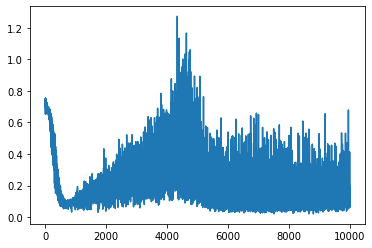

In [10]:
plt.plot(ls_loss_t)

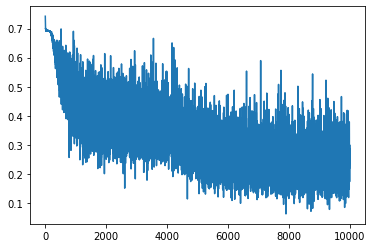

In [11]:
plt.plot(ls_loss_s)

## Meta pseudo labeling evaluation

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

e_net, e_loss, e_sgd = get_model(device)
e_net = load_checkpoint('model/meta-pseudo-labeling/checkpoint_epoch000006857_f1-0.9889889889889889.pth', e_net)


Load checkpoint from: model/meta-pseudo-labeling/checkpoint_epoch000006857_f1-0.9889889889889889.pth


tp 983, fp 8, tn 992, fn 17


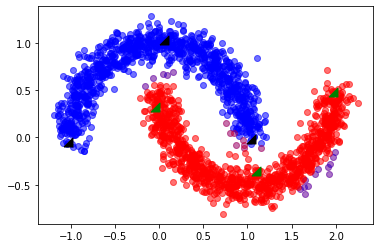

In [16]:
e_net.eval()
y_pred = e_net(torch.tensor(X).to(device).float())
y_pred_np = y_pred.detach().numpy() > 0.5
y_pred_np = y_pred_np.reshape(-1)

tn, fp, fn, tp = confusion_matrix(y, y_pred_np > 0.5).ravel()
print(f'tp {tp}, fp {fp}, tn {tn}, fn {fn}')
plt.scatter(X[y==0,0], X[y==0,1], color='blue', alpha=0.33)
plt.scatter(X[y==1,0], X[y==1,1], color='red', alpha=0.33)


plt.scatter(X[y_pred_np==0,0], X[y_pred_np==0,1], color='blue', alpha=0.33)
plt.scatter(X[y_pred_np==1,0], X[y_pred_np==1,1], color='red', alpha=0.33)

plt.scatter(X[seen_array & (y==0),0], X[seen_array & (y==0),1], s=80, marker=verts, color='black')
plt.scatter(X[seen_array & (y==1),0], X[seen_array & (y==1),1], s=80, marker=verts, color='green')


In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier((8,8), solver='sgd', max_iter = 10000)
mlp.fit(X[seen_idx],y[seen_idx])



MLPClassifier(hidden_layer_sizes=(8, 8), max_iter=10000, solver='sgd')

tp 791, fp 287, tn 710, fn 206


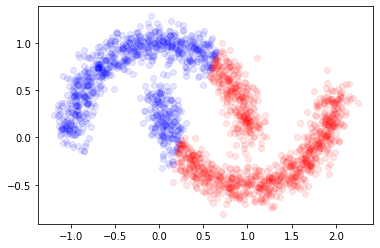

In [18]:
y_pred = mlp.predict(X[unseen_idx])
tn, fp, fn, tp = confusion_matrix(y[unseen_idx], y_pred).ravel()
print(f'tp {tp}, fp {fp}, tn {tn}, fn {fn}')
#plt.scatter(X[y==0,0], X[y==0,1], color='blue', alpha=0.1)
#plt.scatter(X[y==1,0], X[y==1,1], color='red', alpha=0.1)

plt.scatter(X[unseen_idx][y_pred==0,0], X[unseen_idx][y_pred==0,1], color='blue', alpha=0.1)
plt.scatter(X[unseen_idx][y_pred==1,0], X[unseen_idx][y_pred==1,1], color='red', alpha=0.1)